In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel(r'C:\Users\ss4432\TFR\hydrus1.xlsx')
time = data['Time']


In [3]:
infiltration_data = np.where(data['vTop'] < 0, data['vTop'], 0)
precipitation = data['vTop'] + data['SvRoot']

In [4]:
Nx = 10
Ny = 10
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
X, Y = np.meshgrid(x, y)

In [5]:
zb = np.zeros_like(X)
zb += (X - 0.5) * 15 
zb += (Y > 0.5) * (X - 0.7) ** 2 * 10  
zb -= (Y <= 0.5) * (X - 0.3) ** 2 * 5  
zb += (X > 0.7) * 2 

In [6]:
initial_depth = 1.92 
dzb_dx = np.gradient(zb, axis=0)  
slope_x = -dzb_dx
n = 0.008 
g = 9.81  


dt = 0.0001  
dx = 1.0 
dy = 1.0  
time_start = 90  
time_end = 273  

cfl = 0.9
h = np.full((Nx, Ny), initial_depth) 
qx = np.zeros((Nx, Ny))
qy = np.zeros((Nx, Ny))
c = np.mean(np.linspace(0, 1, 10)) 
rho_w = 1000# Density of water in kg/m^3
rho_0 = 1000
rho_s = 2650  # Density of sediment in kg/m^3
p = 0.4  # Bed sediment porosity
d = 0.03
hc = h*c

In [7]:
def safe_operation(value, op='clip', epsilon=1e-10):
    if op == 'clip':
        return np.clip(value, -1e10, 1e10)
    elif op == 'sqrt':
        return np.sqrt(np.maximum(value, 0))
    elif op == 'divide':
        return np.maximum(value, epsilon)

In [8]:
omega = 0.01
def eta_omega(h,omega):
    return (1/np.pi)* np.arctan(h/omega) + 0.5 


In [9]:
def F(U):
    h, qx, hc = U
    h = safe_operation(h, 'divide')  # Prevent division by zero
    u = safe_operation(qx / h)
    v = safe_operation(qy / h)
    
    h_squared = safe_operation(h**2)
    return np.array([qx, qx * u + 0.5 * g * h_squared, qx * safe_operation(hc / h)])

In [10]:
import numpy as np

def compute_source_term(h, c, qx, slope_x, n):
    c = np.clip(c, 0, 1)
    
    u = qx / h  # Flow velocity
    v1 = 1.2e-6
    # Settling velocity (w)
    w =np.sqrt((36 * (v1/d)**2 + 7.5 * rho_s * g * d - 36 * (v1/d))) / 2.8
    
    # Particle Reynolds number (R)
    R = w * d / (1e-6)  
    # m parameter
    m = 6.7
    theta_c = 0.04
    
    # Deposition rate (D)
    D = w * c * ((1 - c) ** m)
    
    # Shields parameter (theta)
    theta = u ** 2 / (g * d * ((rho_s / rho_w) - 1))
    alpha = 1.2*10**-6
    # Entrainment rate (E)
    E = alpha * (theta - theta_c) * u * (h ** -1) * (d ** -0.2) if theta >= theta_c else 0
    rho = rho_w*(1-c)+rho_s*c
    # Friction slope (Sf_x)
    Sf_x = safe_operation((n ** 2 * u**2 ) / (h ** (4 / 3)), epsilon=1e-6)
    
    S1 = eta_omega(h, omega) * (precipitation[t_index] - infiltration_data[t_index])*(E - D) / (1 - p)
    
    S2 = -g * h * (slope_x + Sf_x) \
         - ((rho_s - rho_w) * g * (h**2) * Sf_x) / (2 * rho) \
         - ((rho_0 - rho) * (E - D) * u) / (rho * (1 - p))
    
    S3 = E - D

    return S1, S2, S3

In [11]:
def roe_solver(U_left, U_right, n_x):
    hL, qxL, hcL = U_left
    hR, qxR, hcR = U_right
    hL = safe_operation(hL, 'divide')
    hR = safe_operation(hR, 'divide')
    uL = safe_operation(qxL / hL)
    uR = safe_operation(qxR / hR)
    sqrt_hL = safe_operation(hL, 'sqrt')
    sqrt_hR = safe_operation(hR, 'sqrt')
    h_t = sqrt_hL * sqrt_hR
    u_t = safe_operation((sqrt_hL * uL + sqrt_hR * uR) / (sqrt_hL + sqrt_hR))
    c_t = safe_operation(np.sqrt(g * h_t))
    n_dot_u_t = safe_operation(u_t * n_x)
    lambda_1 = n_dot_u_t - c_t
    lambda_2 = n_dot_u_t
    lambda_3 = n_dot_u_t + c_t
    epsilon1 = np.array([1, n_x * (u_t - c_t), 0])
    epsilon2 = np.array([1, n_x * u_t, 0])
    epsilon3 = np.array([1, n_x * (u_t + c_t), 0])
    delta_U = U_right - U_left
    alpha1 = (delta_U[0] - delta_U[1] / (2 * c_t))
    alpha2 = delta_U[1] - (delta_U[0] + delta_U[1] / c_t)
    alpha3 = (delta_U[0] + delta_U[1] / (2 * c_t))
    F_Roe = 0.5 * (F(U_left) + F(U_right)) - 0.5 * (
        alpha1 * safe_operation(np.abs(lambda_1) * epsilon1) +
        alpha2 * safe_operation(np.abs(lambda_2) * epsilon2) +
        alpha3 * safe_operation(np.abs(lambda_3) * epsilon3)
    )
    
    return F_Roe, np.max(np.abs([lambda_1, lambda_2, lambda_3]))


In [12]:
# Simulation settings
initial_c_values = [0.0, 0.1, 0.2, 0.3 ,0.5, 0.6, 0.8, 0.9, 1.0]
runoff_results = {}
zb_results = {}
time_range = time[(time >= time_start) & (time <= time_end)]  

In [16]:
for initial_c in initial_c_values:
    h = np.full((Nx, Ny), initial_depth)
    qx = np.zeros((Nx, Ny))
    qy = np.zeros((Nx, Ny))
    c = np.full((Nx, Ny), initial_c)

    runoff = [] 
  
    for t_index in range(len(time)):
        max_wave_speed = 0
        
        # Compute max wave speed for CFL condition
        for i in range(1, Nx-1):
            for j in range(1, Ny-1):
                h_ij = h[i, j]
                qx_ij = qx[i, j]
                U = np.array([h_ij, qx_ij, c[i, j]])
                
                # Compute flux and wave speed for neighboring cells
                if j < Ny - 1:
                    U_next = np.array([h[i, j+1], qx[i, j+1], c[i, j+1]])
                    _, wave_speed_y = roe_solver(U, U_next, 1)
                    max_wave_speed = max(max_wave_speed, wave_speed_y)
                if i < Nx - 1:
                    U_next = np.array([h[i+1, j], qx[i+1, j], c[i+1, j]])
                    _, wave_speed_x = roe_solver(U, U_next, 1)
                    max_wave_speed = max(max_wave_speed, wave_speed_x)
        
        cfl_condition = max_wave_speed * dt / dx

        u_max = np.max(np.abs(qx / h))
        cfl_condition = u_max * dt / dx

        if cfl_condition > cfl: 
            raise ValueError(f"CFL condition not satisfied at time step {t_index}. Time step dt is too large.")
        else:
            print(f"Time step {t_index}: CFL condition is satisfied.")
        t = time[t_index]
        if time_start <= t <= time_end:
            for i in range(1, Nx-1):
                for j in range(1, Ny-1):
                    h_ij = h[i, j]
                    qx_ij = qx[i, j]
                    c_ij = c[i, j]
                    k_s = 0.07
                    sediment_factor = 1 / (1 + k_s * c_ij) 

                    U = np.array([h_ij, qx_ij * sediment_factor, c_ij])
                    S1, S2, S3 = compute_source_term(h_ij, c_ij, qx_ij * sediment_factor, slope_x[i, j], n)
                    
                    flux_diff = np.zeros(3)
                    for (di, dj, n_x, n_y) in [(-1, 0, -1, 0), (1, 0, 1, 0), (0, -1, 0, -1), (0, 1, 0, 1)]:
                        ni, nj = i + di, j + dj
                        if 0 <= ni < Nx and 0 <= nj < Ny:
                            U_next = np.array([h[ni, nj], qx[ni, nj] * sediment_factor, c[ni, nj]])
                            F_upwind, _ = roe_solver(U, U_next, n_x)
                            flux_diff -= F_upwind * (n_x * dx + n_y * dy)
                            
                    U_new = U + dt * (flux_diff / dx + np.array([S1, S2, S3]))
                    h[i, j], qx[i, j], c[i, j] = U_new

                    # Enforce non-negative sediment concentration
                    if c[i, j] < 0:
                       c[i, j] = 0

                    c[i, j] = np.clip(c[i, j], 0, 1)
                    # Update bed elevation based on the erosion-deposition balance
                    zb[i, j] -= -S3 * dt / (1 - p)

            # Update slope gradients after changing bed elevation
            dzb_dx = np.gradient(zb, axis=0)
            slope_x = -dzb_dx
            
            # Neumann boundary conditions (copy from adjacent cells)
            qx[0, :] = qx[1, :] * sediment_factor
            qx[-1, :] = qx[-2, :] * sediment_factor
            h[0, :] = h[1, :]
            h[-1, :] = h[-2, :]

            qy[:, 0] = qy[:, 1] * sediment_factor
            qy[:, -1] = qy[:, -2] * sediment_factor
            h[:, 0] = h[:, 1]
            h[:, -1] = h[:, -2]

            runoff.append(np.sum(qx[-2, :]))
        runoff_results[initial_c] = runoff

Time step 0: CFL condition is satisfied.
Time step 1: CFL condition is satisfied.
Time step 2: CFL condition is satisfied.
Time step 3: CFL condition is satisfied.
Time step 4: CFL condition is satisfied.
Time step 5: CFL condition is satisfied.
Time step 6: CFL condition is satisfied.
Time step 7: CFL condition is satisfied.
Time step 8: CFL condition is satisfied.
Time step 9: CFL condition is satisfied.
Time step 10: CFL condition is satisfied.
Time step 11: CFL condition is satisfied.
Time step 12: CFL condition is satisfied.
Time step 13: CFL condition is satisfied.
Time step 14: CFL condition is satisfied.
Time step 15: CFL condition is satisfied.
Time step 16: CFL condition is satisfied.
Time step 17: CFL condition is satisfied.
Time step 18: CFL condition is satisfied.
Time step 19: CFL condition is satisfied.
Time step 20: CFL condition is satisfied.
Time step 21: CFL condition is satisfied.
Time step 22: CFL condition is satisfied.
Time step 23: CFL condition is satisfied.
Ti

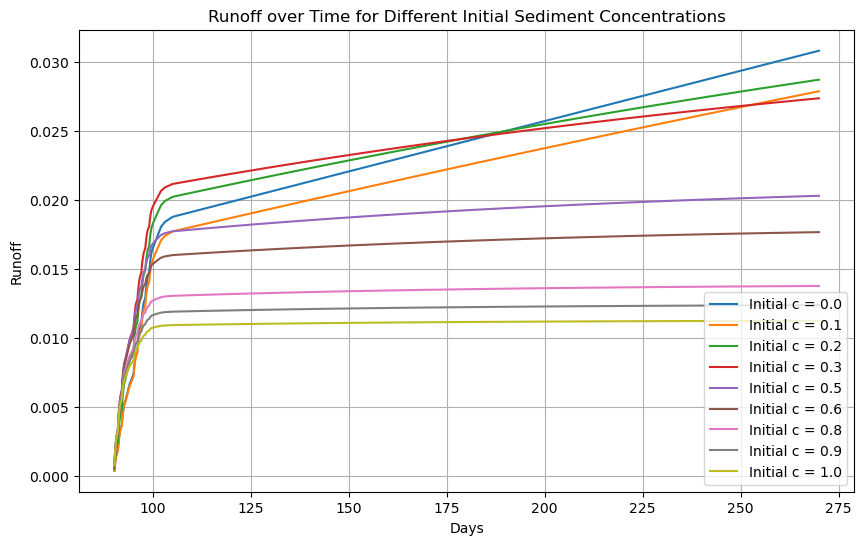

In [16]:
plt.figure(figsize=(10, 6))
for initial_c, runoff in runoff_results.items():
    plt.plot(time_range, runoff[:len(time_range)], label=f'Initial c = {initial_c}')

plt.title('Runoff over Time for Different Initial Sediment Concentrations')
plt.xlabel('Days')
plt.ylabel('Runoff')
plt.legend()
plt.grid(True)
plt.show()


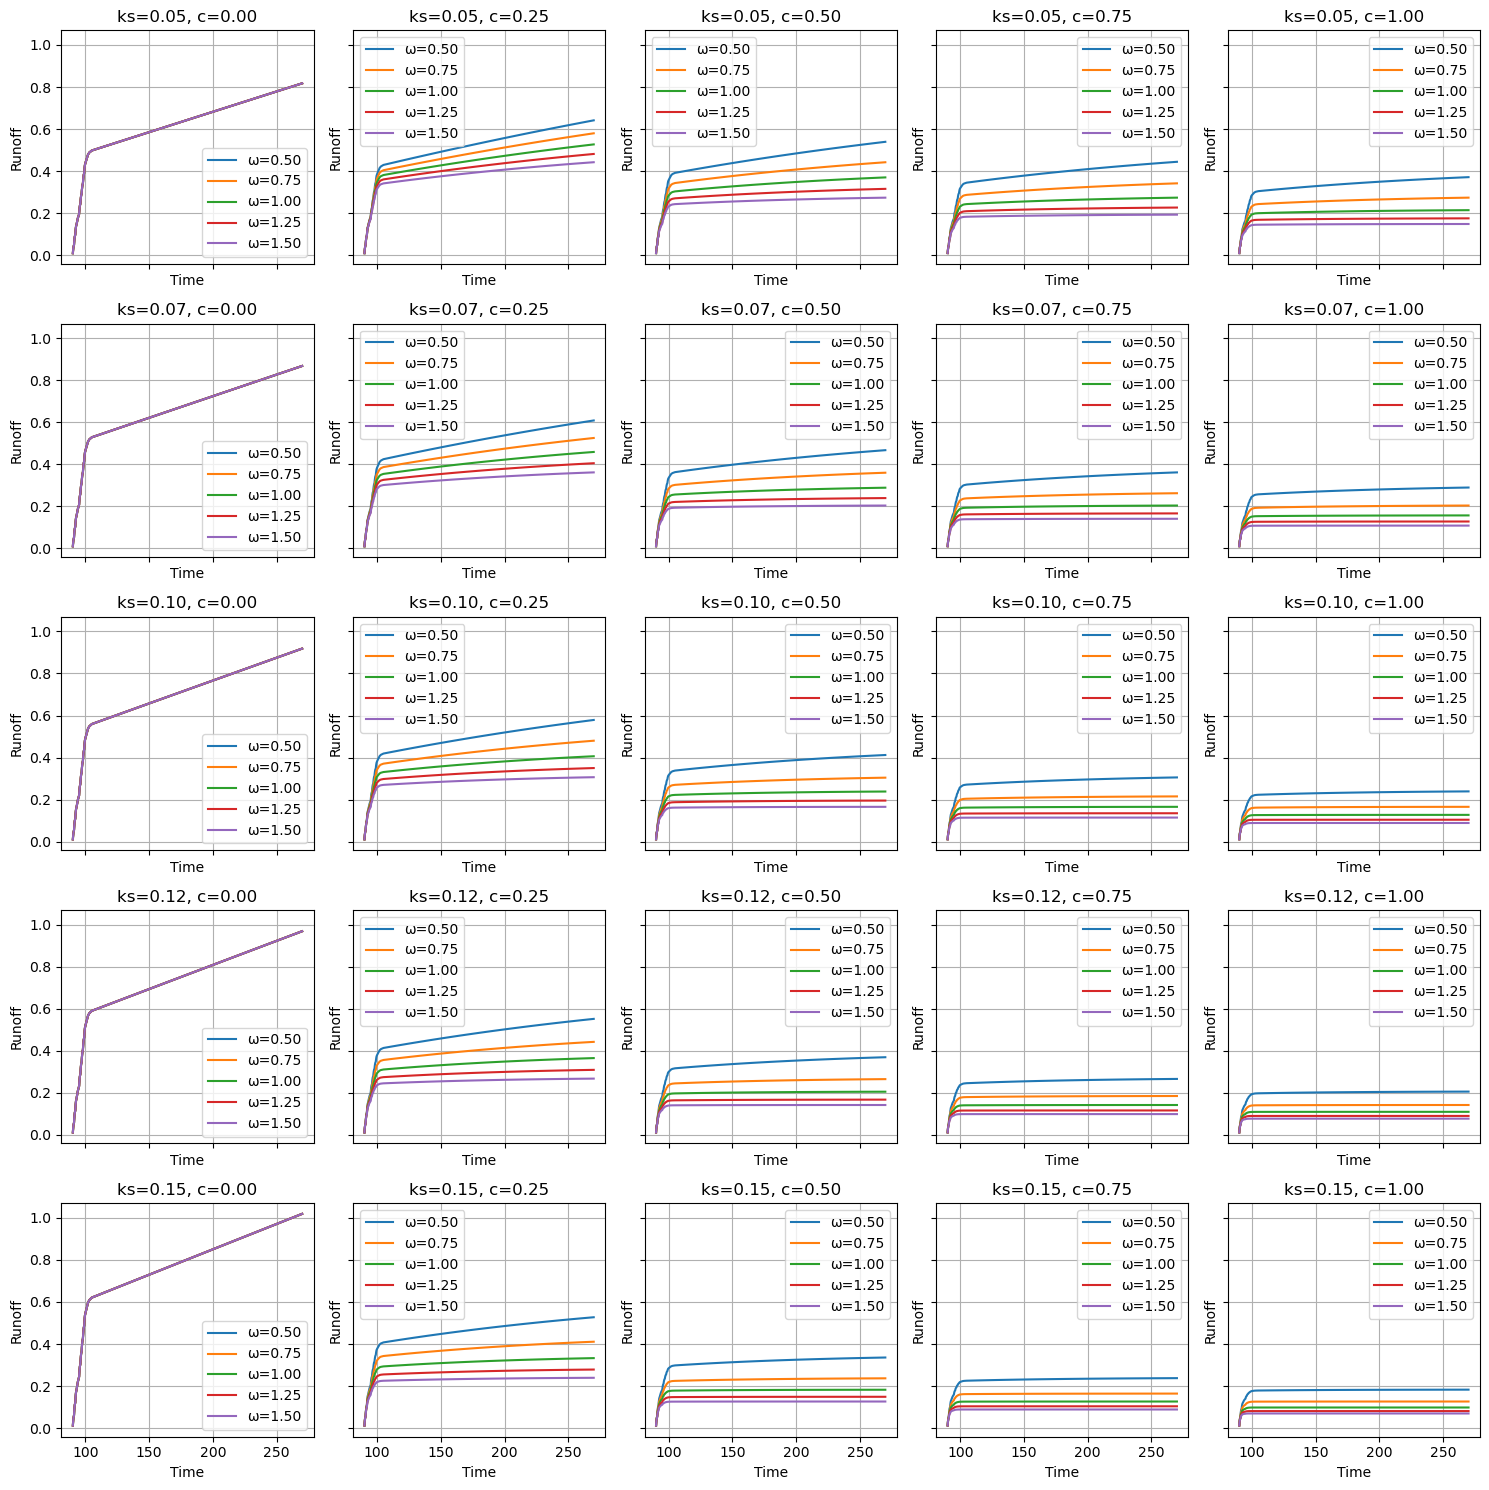

In [20]:
# Sensitivity analysis loop
for ks in ks_values:
    for initial_c in initial_c_values:
        for omega in omega_values:
            h = np.full((Nx, Ny), initial_depth)
            qx = np.zeros((Nx, Ny))
            qy = np.zeros((Nx, Ny))
            c = np.full((Nx, Ny), initial_c)

            runoff = [] 

            for t_index in range(len(time)):
                t = time[t_index]
                if time_start <= t <= time_end:
                    for i in range(1, Nx-1):
                        for j in range(1, Ny-1):
                            h_ij = h[i, j]
                            qx_ij = qx[i, j]
                            c_ij = c[i, j]
                            
                            # Introduce a factor that reduces qx based on sediment concentration
                            sediment_factor = 1 / (1 + ks * c_ij * omega)  # ks and omega are parameters

                            U = np.array([h_ij, qx_ij * sediment_factor, c_ij])
                            S1, S2, S3 = compute_source_term(h_ij, c_ij, qx_ij * sediment_factor, slope_x[i, j], n)

                            flux_diff = np.zeros(3)
                            for (di, dj, n_x, n_y) in [(-1, 0, -1, 0), (1, 0, 1, 0), (0, -1, 0, -1), (0, 1, 0, 1)]:
                                ni, nj = i + di, j + dj
                                if 0 <= ni < Nx and 0 <= nj < Ny:
                                    U_next = np.array([h[ni, nj], qx[ni, nj] * sediment_factor, c[ni, nj]])
                                    F_upwind = roe_solver(U, U_next, n_x)
                                    flux_diff -= F_upwind * (n_x * dx + n_y * dy)

                            U_new = U + dt * (flux_diff / dx + np.array([S1, S2, S3]))
                            h[i, j], qx[i, j], c[i, j] = U_new
                            c[i, j] = np.clip(c[i, j], 0, 1)
                            zb[i, j] -= -S3 * dt / (1 - p)

                    dzb_dx = np.gradient(zb, axis=0)
                    slope_x = -dzb_dx

                    # Neumann boundary conditions (copy from adjacent cells)
                    qx[0, :] = qx[1, :] * sediment_factor
                    qx[-1, :] = qx[-2, :] * sediment_factor
                    h[0, :] = h[1, :]
                    h[-1, :] = h[-2, :]

                    qy[:, 0] = qy[:, 1] * sediment_factor
                    qy[:, -1] = qy[:, -2] * sediment_factor
                    h[:, 0] = h[:, 1]
                    h[:, -1] = h[:, -2]

                    runoff.append(np.sum(qx[-2, :]))

            # Store results for this combination of ks, initial_c, and omega
            sensitivity_results[(ks, initial_c, omega)] = runoff

# Plotting the results of the sensitivity analysis
fig, ax = plt.subplots(len(ks_values), len(initial_c_values), figsize=(15, 15), sharex=True, sharey=True)

for i, ks in enumerate(ks_values):
    for j, initial_c in enumerate(initial_c_values):
        for omega in omega_values:
            key = (ks, initial_c, omega)
            if key in sensitivity_results:
                runoff = sensitivity_results[key]
                
                # Ensure time and runoff have the same length
                min_length = min(len(time), len(runoff))
                time_truncated = time[:min_length]
                runoff_truncated = runoff[:min_length]
                
                ax[i, j].plot(time_truncated, runoff_truncated, label=f'ω={omega:.2f}')

        ax[i, j].set_title(f'ks={ks:.2f}, c={initial_c:.2f}')
        ax[i, j].set_xlabel('Time')
        ax[i, j].set_ylabel('Runoff')
        ax[i, j].legend(loc='best')
        ax[i, j].grid(True)

plt.tight_layout()
plt.show()

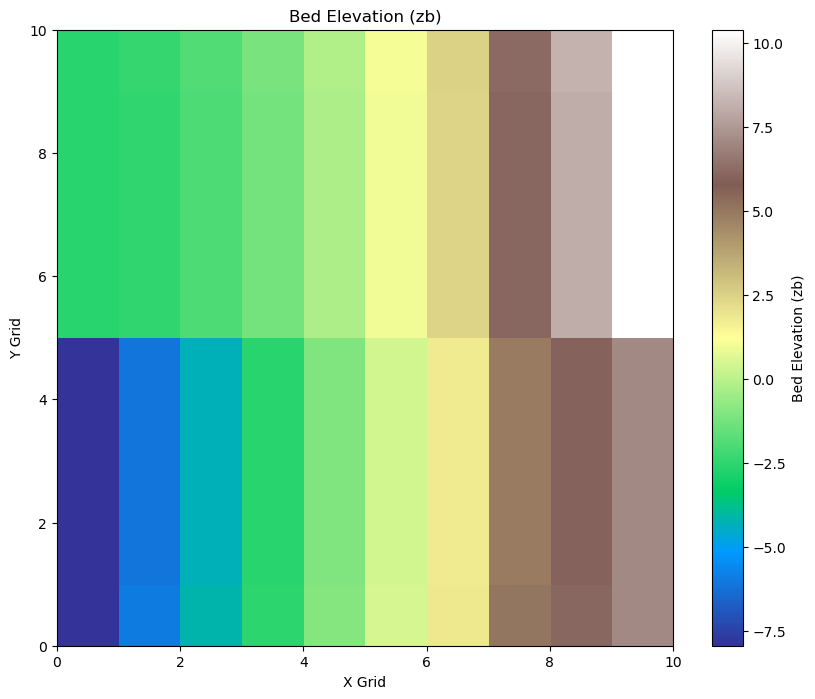

In [17]:
# Plotting the bed elevation (zb)
def plot_zb(zb):
    plt.figure(figsize=(10, 8))
    plt.imshow(zb, cmap='terrain', origin='lower', extent=[0, zb.shape[1], 0, zb.shape[0]])
    plt.colorbar(label='Bed Elevation (zb)')
    plt.title('Bed Elevation (zb)')
    plt.xlabel('X Grid')
    plt.ylabel('Y Grid')
    plt.show()
    
plot_zb(zb)

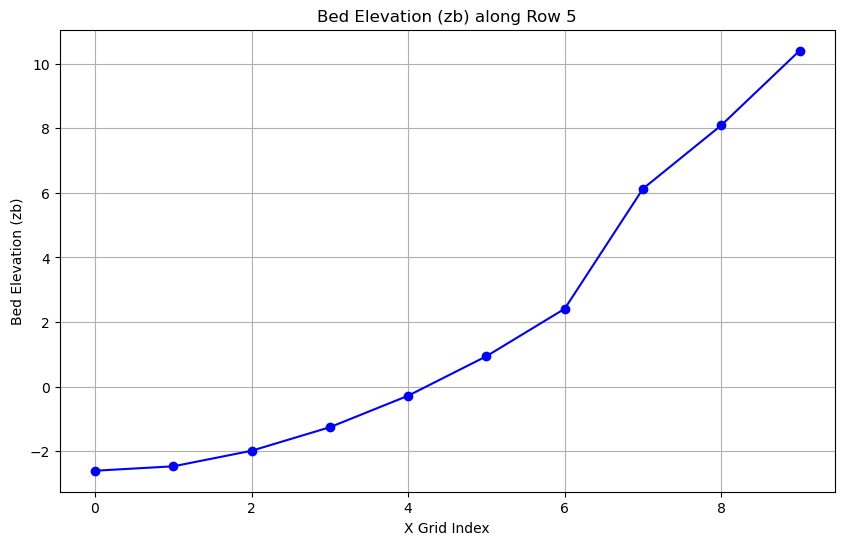

In [18]:
# Choose a specific row or column to plot
row_to_plot = 5  # You can change this to any row index you're interested in

# Plotting the bed elevation along the chosen row
plt.figure(figsize=(10, 6))
plt.plot(zb[row_to_plot, :], marker='o', linestyle='-', color='b')
plt.title(f'Bed Elevation (zb) along Row {row_to_plot}')
plt.xlabel('X Grid Index')
plt.ylabel('Bed Elevation (zb)')
plt.grid(True)
plt.show()

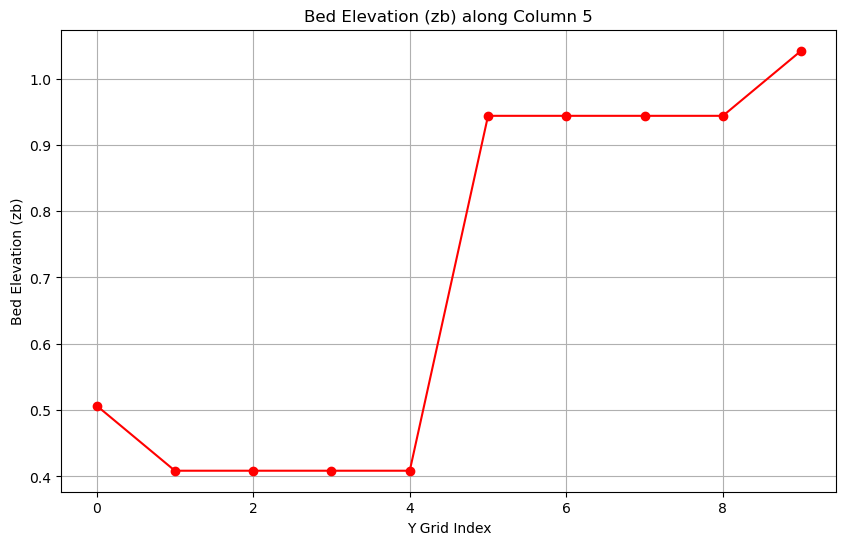

In [19]:
# Choose a specific column to plot
column_to_plot = 5  # You can change this to any column index you're interested in

# Plotting the bed elevation along the chosen column
plt.figure(figsize=(10, 6))
plt.plot(zb[:, column_to_plot], marker='o', linestyle='-', color='r')
plt.title(f'Bed Elevation (zb) along Column {column_to_plot}')
plt.xlabel('Y Grid Index')
plt.ylabel('Bed Elevation (zb)')
plt.grid(True)
plt.show()

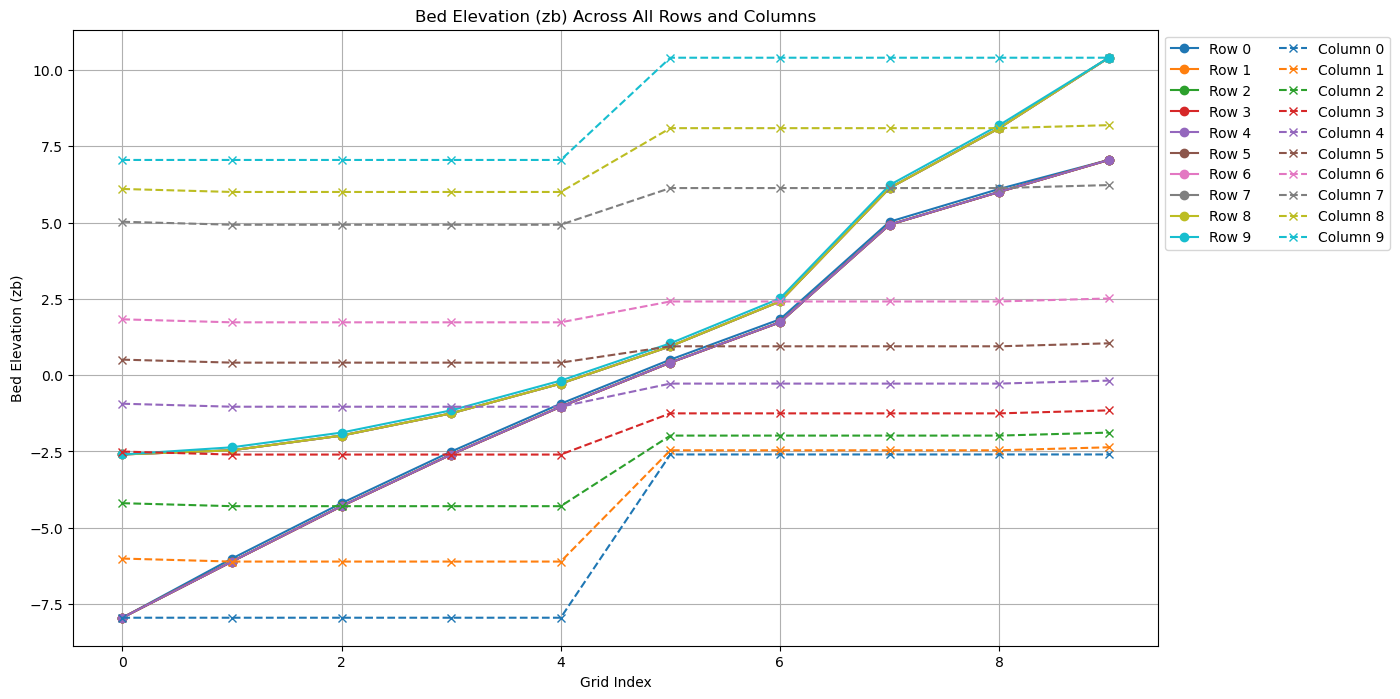

In [18]:
import matplotlib.pyplot as plt

# Plotting all rows and columns in a single plot
plt.figure(figsize=(14, 8))

# Plot all rows
for i in range(zb.shape[0]):
    plt.plot(zb[i, :], label=f'Row {i}', linestyle='-', marker='o')

# Plot all columns
for i in range(zb.shape[1]):
    plt.plot(zb[:, i], label=f'Column {i}', linestyle='--', marker='x')

plt.title('Bed Elevation (zb) Across All Rows and Columns')
plt.xlabel('Grid Index')
plt.ylabel('Bed Elevation (zb)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)  # Adjust the legend position and layout
plt.grid(True)
plt.show()


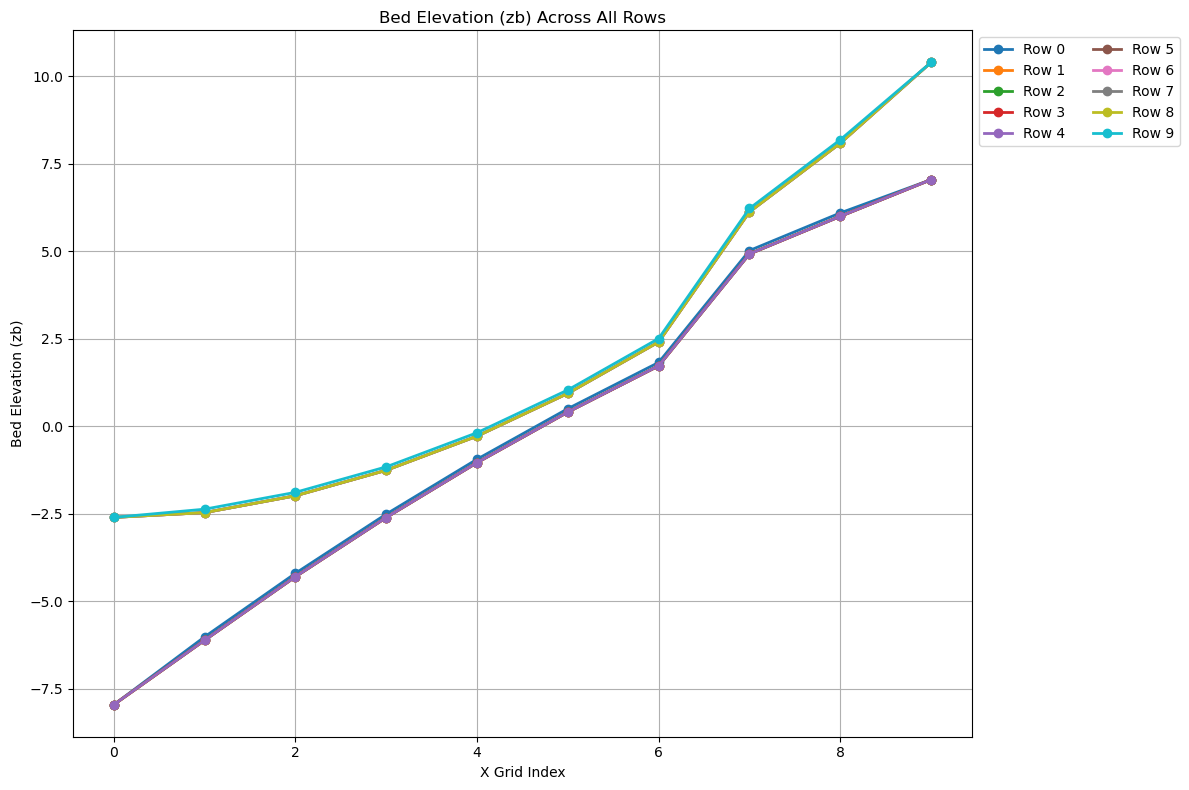

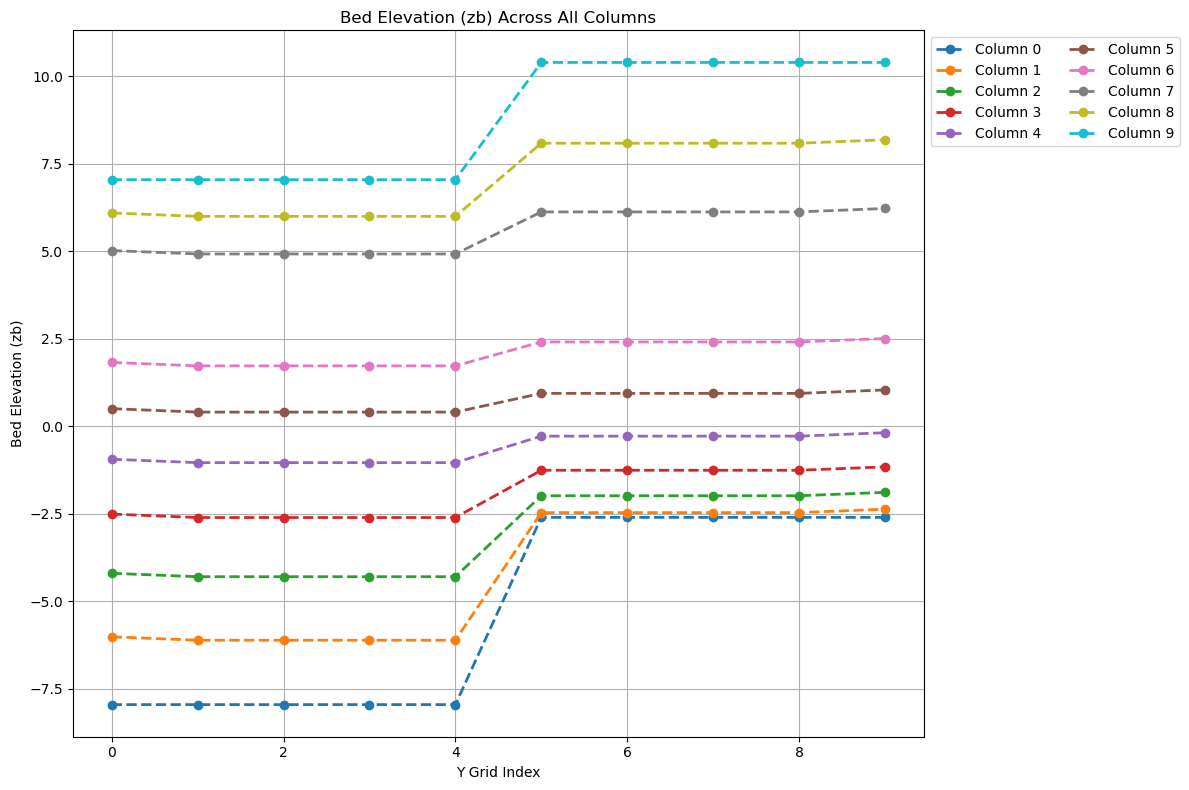

In [22]:
import matplotlib.pyplot as plt

# Plot for all rows
plt.figure(figsize=(12, 8))
for i in range(zb.shape[0]):
    plt.plot(zb[i, :], marker='o', linestyle='-', linewidth=2, label=f'Row {i}')
plt.title('Bed Elevation (zb) Across All Rows')
plt.xlabel('X Grid Index')
plt.ylabel('Bed Elevation (zb)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2) 
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot for all columns
plt.figure(figsize=(12, 8))
for i in range(zb.shape[1]):
    plt.plot(zb[:, i], marker='o', linestyle='--', linewidth=2, label=f'Column {i}')
plt.title('Bed Elevation (zb) Across All Columns')
plt.xlabel('Y Grid Index')
plt.ylabel('Bed Elevation (zb)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2) 
plt.grid(True)
plt.tight_layout()
plt.show()

